# Synapse Visualizer

This notebook is modified from Allen Institute tutorial on working with Meshes by Forrest Collman  
The original tutorial is located here:   https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/intro/MeshExample.ipynb

# Python Requirements
You will need to run this notebook in a Python 3.7 environment  
Sometime meshparty will have a conflict with other tools and not work properly in Anaconda  
If that happens, you will need to start over with a new Anaconda environment  
Install allensdk first, then meshparty, then any other other tools desired  
The installation described below worked well:  
* Install new environment v3.7 in Anaconda
* conda install jupyter
* pip install allensdk
* pip install meshparty
* pip install caveclient
* pip install 'itkwidgets[notebook]>=1.0a8'
* pip install --upgrade --pre itk
* pip install gdown

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils

In [3]:
# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/neuron_meshes_v185/' # or change to your desired folder
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

In [4]:
# enter a cell id of interest (copy and paste from Neuroglancer or a dataframe of interest)

cell_id = 648518346349538235

#some interesting neurons

# 648518346349538440 this excitatory pyramidal neuron has the most total synapses in the volume
# 648518346349539215 this inhibitory basket neuron has the most pre-synaptic sites in the volume
# 648518346349536971 no soma in the volume, appears to have an axon-carrying dendrite
# 648518346349515985 this inhibitory neuron of unknown subtype has 5 pre-synaptic sites that appears to be on dendrites
# 648518346349508279 not a neuron; this is an oligodendrocyte which has synaptic sites most likely due to mis-segmentation
# 648518346349537741 the largest continous mitochondrion by voxels, for an excitatory pyramidal neuron in the volume
# 648518346349538791 the largest continous mitochondrion by voxels, for an inhibitory neuron in the volume (basket) 
# 648518346349537611 partial excitatory pyramidal neuron with interesting mitochondria and synapse features

In [5]:
# If you get an error, run the next cell to download the mesh, then rerun this cell again
seg_id = cell_id
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(filename = mesh_file)

In [6]:
# If you get an error on the previous cell, run this cell
# After the mesh is successfully downloaded, rerun the previous cell 
downloadmesh = mm.mesh(seg_id = seg_id, remove_duplicate_vertices=True)

In [7]:
seg_id

648518346349538235

In [8]:
mesh_file

'data/neuron_meshes_v185/648518346349538235.h5'

In [9]:
mesh.n_vertices, mesh.n_faces

(1448352, 2895512)

In [10]:
# read in the full synapse table
soma_subgraph_df = pd.read_csv('data/pni_synapses_v185.csv')

In [11]:
soma_subgraph_df

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239270,2865917,648518346348045782,648518346349537840,106,268776,173356,14360,67190,43302,361,67194,43339,359,67216,43364,360
3239271,3386018,648518346347834064,648518346349537840,50,267344,156520,8520,66762,39152,213,66836,39130,213,66874,39134,213
3239272,2940412,648518346347876810,648518346349537840,139,292772,156680,12600,73136,39170,315,73193,39170,315,73218,39160,315
3239273,2682848,648518346348343883,648518346349537840,987,462768,237776,8520,115680,59370,208,115692,59444,213,115628,59430,214


In [12]:
# filter all the pre- and post- synapses for this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}') #this shows all post-syn sites on this seg_id cell
cell_pre_subgraph = soma_subgraph_df.query(f'pre_root_id=={seg_id}') #this one shows all pre-syn sites on the axon of seg_id cell

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
presyn_xyz=cell_pre_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(304642.6875, 144633.40625)

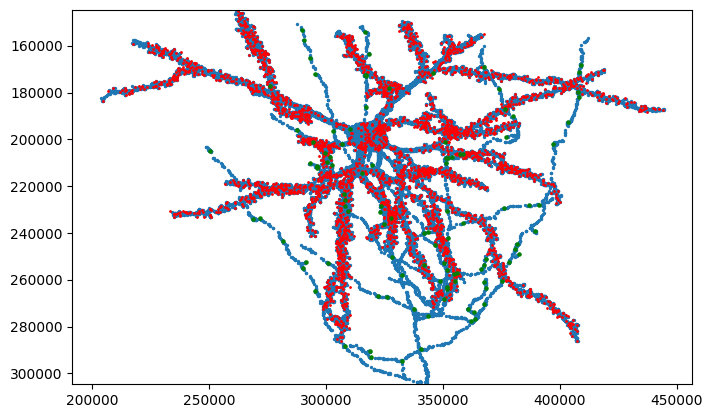

In [13]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=1) # modify s and alpha to improve the visualization

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=5, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [14]:
len(postsyn_xyz)

3143

In [15]:
len(presyn_xyz)

108

In [16]:
# Make a list of the pre_root_ids that form a synapse on this cell
cell_post_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
883698,1153987,648518346349533350,648518346349538235,174,405688,177128,5800,101462,44338,143,101422,44282,145,101386,44258,146
2640546,3309771,648518346347453098,648518346349538235,593,353864,253160,36120,88406,63290,901,88466,63290,903,88460,63260,900
2648939,3344829,648518346346318269,648518346349538235,126,323792,193688,62360,80974,48402,1558,80948,48422,1559,80910,48430,1559
2670562,2185605,648518346349538291,648518346349538235,418,307888,228016,14520,76998,56972,364,76972,57004,363,76948,57020,364
2670564,237817,648518346349537514,648518346349538235,473,300604,269276,27080,75094,67356,681,75151,67319,677,75082,67290,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132253,578433,648518346342927053,648518346349538235,111,358104,204704,23960,89504,51134,599,89526,51176,599,89562,51218,599
3132254,587478,648518346345323204,648518346349538235,112,229336,163832,38200,57372,41000,955,57334,40958,955,57294,40944,955
3132255,608979,648518346342801626,648518346349538235,114,306288,229384,43960,76498,57362,1100,76572,57346,1099,76598,57342,1100
3132256,614993,648518346342797588,648518346349538235,292,299956,209464,64160,74974,52386,1607,74989,52366,1604,74910,52360,1607


In [17]:
# Uncomment if you want to generate a list for copy and pasting
# cell_post_subgraph["pre_root_id"].to_list()

In [18]:
# Make a list of the post_root_ids that receive a synapse from this cell
cell_pre_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
9475,91386,648518346349538235,648518346347606459,68,326816,177832,14920,81752,44440,372,81704,44458,373,81682,44476,373
10198,92394,648518346349538235,648518346341400741,199,375024,260616,75080,93724,65124,1879,93756,65154,1877,93782,65184,1880
47895,3998,648518346349538235,648518346342927414,62,276248,177288,37200,69096,44338,930,69062,44322,930,69028,44316,930
59629,2471277,648518346349538235,648518346349531742,630,307032,202144,23920,76690,50550,597,76758,50536,598,76706,50482,597
63865,2052671,648518346349538235,648518346349534855,389,319732,210992,56160,79898,52718,1405,79933,52748,1404,79900,52780,1403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124376,1098834,648518346349538235,648518346349525919,167,357352,206320,59120,89328,51626,1480,89338,51580,1478,89338,51514,1480
3124377,2632522,648518346349538235,648518346349522740,872,332640,294640,65680,83088,73690,1643,83160,73660,1642,83152,73606,1643
3124378,706971,648518346349538235,648518346349537741,52,327816,233412,74040,81956,58380,1843,81954,58353,1851,81864,58380,1843
3124379,120913,648518346349538235,648518346349537985,71,296184,211232,8960,74006,52852,223,74046,52808,224,74030,52770,223


In [19]:
# Uncomment if you will to generate a list for copy and pasting
# cell_pre_subgraph["post_root_id"].to_list()

In [20]:
# 3D visualizer using OpenGL and vtk tool
# You must have OpenGL installed on your computer

import vtk

In [21]:
# Use this visualization if you do NOT want to see the synaptic sites (cell mesh only)

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired

#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x00000212F5F197F0) at 0x0000021302D9CA68>

In [22]:
# Use this visualization if you want to see the synaptic sites

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired
presyn_actor = trimesh_vtk.point_cloud_actor(presyn_xyz, size=500, color=(0.2, 0.9, 0.2)) #adjust size and color if desired 
postsyn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=250, color=(0.9, 0.2, 0.2)) #adjust size and color if desired


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,presyn_actor, postsyn_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x00000212F6770040) at 0x0000021302AAC948>